# Projet : Clustering avec K-means et ses variantes (MAGIC Gamma Telescope)

## Objectif
L’objectif de ce travail est de pratiquer l’analyse de données et le clustering
à travers le jeu de données **MAGIC Gamma Telescope** (UCI).
Il s’agit de comparer différentes variantes de **K-means** en fonction
des caractéristiques du jeu de données, d’évaluer leurs performances
avec des métriques internes (sans labels), puis de compléter l’analyse
par des métriques externes (avec labels disponibles).
Enfin, on étudiera l’effet de la réduction de dimension (PCA) sur les résultats.

## Tâches à réaliser
1. **Étudier les données**  
   - Nombre d’instances, nombre et nature des variables (features), présence/absence de valeurs manquantes, description des classes.

2. **Analyser les variantes de K-means** (scikit-learn)  
   - Identifier les différentes variantes disponibles.  

3. **Choisir une variante adaptée**  
   - Justifier le choix en fonction des caractéristiques du dataset.  
   - Implémenter l’algorithme et déterminer le **nombre optimal de clusters k**.

4. **Comparer avec K-means standard**  
   - Même nombre de clusters.  
   - Utiliser des **métriques internes** (silhouette, Davies–Bouldin, etc.).  
   - En complément, utiliser des **métriques externes** (pureté, ARI) grâce aux labels disponibles (gamma/hadron).

5. **Étudier l’effet d’une réduction de dimension (PCA)**  
   - Réduire à 2-3 dimensions.  
   - Refaire le clustering et comparer avec les résultats d’origine.


## 1) Étude des données

Nous utilisons le jeu de données **MAGIC Gamma Telescope** (UCI).  
Il provient de simulations Monte Carlo (programme *CORSIKA*) d’un télescope Cherenkov atmosphérique au sol (MAGIC).  
Le télescope observe les gerbes atmosphériques produites par des particules gamma de haute énergie.  
Ces gerbes créent une **tache lumineuse allongée** sur le plan de la caméra.  
Après prétraitement, cette tache est approximée par une **ellipse** grâce à une ACP (PCA).  
On en extrait un ensemble de paramètres géométriques et d’intensité appelés **Hillas parameters**.

Ces paramètres permettent de distinguer deux types d’événements :  
- **gamma (signal)** : cascades électromagnétiques produites par les rayons gamma,  
- **hadron (bruit de fond)** : cascades hadroniques produites par des rayons cosmiques.

### Caractéristiques principales
- **Nombre d’instances** : 19 020  
- **Nombre de variables** : 10 (toutes continues, aucune valeur manquante)  
- **Classes** : deux catégories  
  - `g = gamma (signal)` : 12 332 (~64,8 %)  
  - `h = hadron (bruit de fond)` : 6 688 (~35,2 %)  
  Dans les vraies données, les hadrons devraient être majoritaires → ils sont sous-estimés ici.  

Pour le clustering non supervisé, **les labels ne seront pas utilisés**.  
Ils serviront uniquement à l’**évaluation externe** (pureté, ARI, NMI).

### Variables (features)

1. **fLength** : axe majeur de l’ellipse (mm) – reflète l’allongement de la tache lumineuse.  
2. **fWidth** : axe mineur de l’ellipse (mm) – reflète la largeur de la tache.  
3. **fSize** : log (base 10) de la somme des intensités (# photons) – correspond à la luminosité totale.  
4. **fConc** : deux pixels les plus brillants / fSize – mesure la concentration de la lumière.  
5. **fConc1** : pixel le plus brillant / fSize – concentration sur un seul pixel.  
6. **fAsym** : distance du pixel le plus lumineux au centre sur l’axe majeur – indique l’asymétrie de l’image.  
7. **fM3Long** : racine cubique du 3ᵉ moment le long de l’axe majeur – caractérise la distribution sur la longueur.  
8. **fM3Trans** : racine cubique du 3ᵉ moment le long de l’axe mineur – caractérise la distribution sur la largeur.  
9. **fAlpha** :angle entre l’axe majeur et le vecteur vers l’origine (°) – indique l’orientation de la tache.  
10. **fDist** :distance entre l’origine (centre caméra) et le centre de l’ellipse (mm) – indique la position de l’événement dans le champ de vision.



## 2) Variantes de K-means dans scikit-learn (définitions + à quels problèmes elles répondent)

### KMeans (avec initialisation **k-means++**)
- **Définition** : partitionne en `k` groupes en minimisant l’**inertie** (somme intra-cluster des carrés). L’initialisation `k-means++` choisit des centroïdes mieux espacés et accélère la convergence. :contentReference[oaicite:0]{index=0}  
- **Problème adressé** : **sensibilité à l’initialisation** (aléatoire) et convergence lente / solutions de mauvaise qualité ; `k-means++` rend l’algorithme plus stable et plus rapide. :contentReference[oaicite:1]{index=1}  
- **Hypothèses d’usage** : clusters **à variance similaire** et plutôt **isotropes** (distance euclidienne), données **mises à l’échelle**. :contentReference[oaicite:2]{index=2}  
- **API** : `KMeans(n_clusters=k, init="k-means++", n_init="auto", random_state=0)`. 
---

### MiniBatchKMeans
- **Définition** : variante incrémentale qui met à jour les centroïdes à partir de **mini-lots** (sous-échantillons), au lieu de balayer tout `X` à chaque itération. :contentReference[oaicite:4]{index=4}  
- **Problème adressé** : **grands volumes** de données (mémoire/temps). Légère perte de précision vs KMeans, mais **beaucoup plus rapide** et **moins coûteux**. :contentReference[oaicite:5]{index=5}  
- **Quand l’utiliser** : datasets très gros, répétitions nombreuses (plusieurs `k`, plusieurs redémarrages) ou contraintes mémoire. :contentReference[oaicite:6]{index=6}  
- **API** : `MiniBatchKMeans(n_clusters=k, random_state=0)`. 

---

### BisectingKMeans
- **Définition** : approche **hiérarchique descendante** : on commence à `k=2`, puis on **bifurque** itérativement un des clusters (souvent celui à plus forte inertie) jusqu’à obtenir `k` groupes. :contentReference[oaicite:8]{index=8}  
- **Problème adressé** : **manque de continuité** de KMeans quand `k` change (les partitions pour `k` et `k+1` n’héritent pas l’une de l’autre). BisectingKMeans produit une structure **plus régulière** et **interprétable** à grande échelle. :contentReference[oaicite:9]{index=9}  
- **Quand l’utiliser** : besoin d’une **structure hiérarchique** ou d’une **trajectoire cohérente** des partitions quand on augmente `k`. :contentReference[oaicite:10]{index=10}  
- **API** : `BisectingKMeans(n_clusters=k, random_state=0)`. 



### Indicateurs d’évaluation du clustering

#### 1) Indicateurs internes (sans labels)
Ils permettent surtout de **choisir le nombre de clusters k** et de comparer différents algorithmes sur la base de la compacité et de la séparation des groupes:
- **Inertia (SSE)** : Somme des distances au carré à l’intérieur des clusters.
C’est la fonction objectif par défaut de KMeans.
Plus c’est petit, mieux c’est.
Mais cela diminue toujours quand $k$ augmente, donc on l’utilise avec la « règle du coude ».
- **Silhouette coefficient** : Mesure la compacité d’un échantillon dans son cluster par rapport à la séparation avec le cluster le plus proche.
Valeurs entre [-1, 1].
Plus proche de 1, mieux c’est.
Souvent utilisé pour choisir $k$.  
- **Davies–Bouldin Index (DBI)** : Rapport entre la similarité inter-clusters et la compacité intra-cluster.
Plus c’est petit, mieux c’est.
Adapté pour comparer différents $k$ ou différents algorithmes. 
- **Calinski–Harabasz Index (CH)** : Rapport entre la dispersion inter-clusters et intra-clusters.
Plus c’est grand, mieux c’est.
Calcul rapide, souvent utilisé pour comparer rapidement. 

#### 2) Indicateurs externes (avec labels)
Ils ne servent pas à entraîner l’algorithme mais à **vérifier a posteriori** si la structure trouvée par le clustering correspond bien aux classes réelles.   :
- **Purity** : proportion d’éléments bien classés dans le cluster dominant. Entre 0 et 1.  
- **ARI (Adjusted Rand Index)** : compare les paires d’éléments dans les clusters vs. dans les vraies classes. Entre -1 et 1, 1 = partition parfaite.  
- **NMI (Normalized Mutual Information)** : mesure la similarité entre clustering et vraies classes. Entre 0 et 1.  
- **Accuracy** : possible, mais moins informatif car la distribution des classes est déséquilibrée (gamma > hadron).  

Dans ce projet, on peut donc d’abord s’appuyer sur les indicateurs internes pour déterminer k et comparer les variantes, puis utiliser les indicateurs externes comme validation complémentaire.


## 3) Choisir une variante de K-means et déterminer le nombre optimal de clusters *k*

**Idée générale.**  
Le jeu de données (19 020 × 10) n’est pas massif ; **KMeans (k-means++)** est une base solide (initialisation fiable, convergence rapide).  
Cependant, pour rester objectif, on **évalue trois variantes** sur une grille de *k* :  
- **KMeans (k-means++)** – stabilité à l’initialisation ;  
- **MiniBatchKMeans** – utile surtout pour très grands volumes (ici, référence/contre-exemple) ;  
- **BisectingKMeans** – structure hiérarchique, partitions plus “régulières”.

**Critères internes utilisés** (sans labels) :  
- **Inertia (SSE)** ↓（avec “méthode du coude”）；  
- **Silhouette** ↑；  
- **Davies–Bouldin (DBI)** ↓；  
- **Calinski–Harabasz (CH)** ↑。

**Procédure.**  
1) Standardiser les features (K-means est sensible aux échelles).  
2) Pour chaque variante et pour *k* ∈ {2,…,8} : entraîner, puis calculer Silhouette/DBI/CH/Inertia.  
3) Visualiser les courbes vs *k*（coude + Silhouette/DBI/CH）。  
4) Proposer un couple (**variante**, **k**) au meilleur compromis（Silhouette↑, DBI↓, CH↑；Inertia）。  
5) Si plusieurs variantes sont ex aequo, privilégier **KMeans (k-means++)**（simple, stable, reproductible）。



In [1]:
# --- Imports de base ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, BisectingKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# --- Chargement des données UCI ---
cols = ["fLength","fWidth","fSize","fConc","fConc1","fAsym",
        "fM3Long","fM3Trans","fAlpha","fDist","class"]
df = pd.read_csv("magic04.data", header=None, names=cols)

# Séparation X / y (y non utilisé ici, réservé pour Q4)
X = df.drop(columns=["class"]).values
y = df["class"].values

# --- Mise à l’échelle (indispensable pour K-means) ---
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

print(df.shape, " | Aucune valeur manquante:", not df.isna().any().any())

(19020, 11)  | Aucune valeur manquante: True


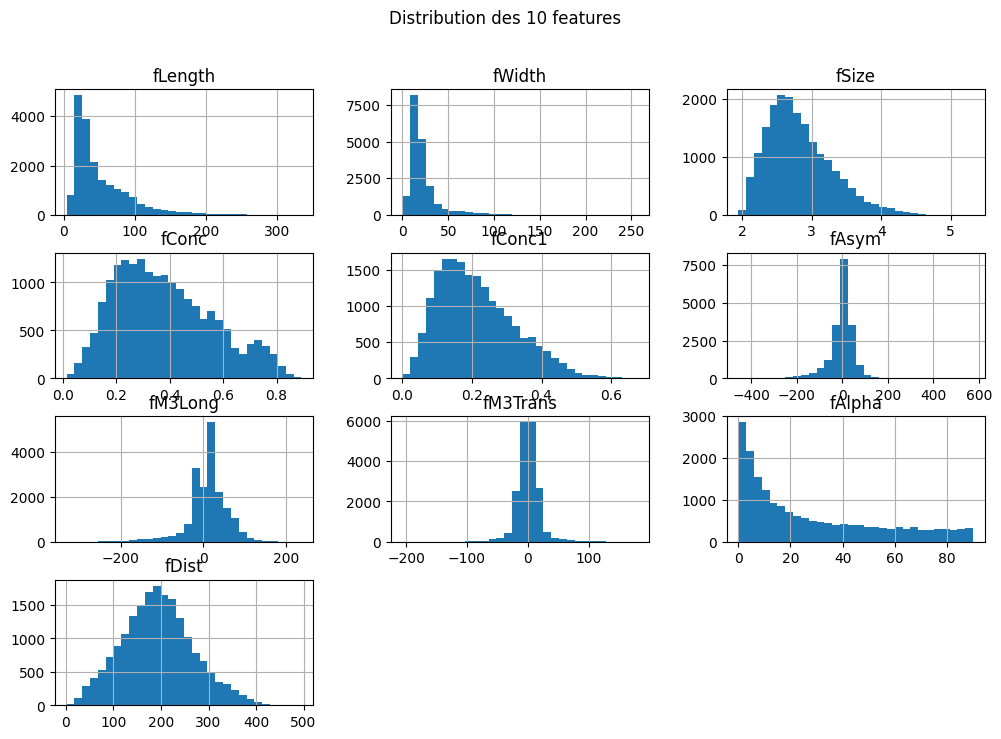

In [2]:
import matplotlib.pyplot as plt

df.drop(columns="class").hist(figsize=(12,8), bins=30)
plt.suptitle("Distribution des 10 features")
plt.show()

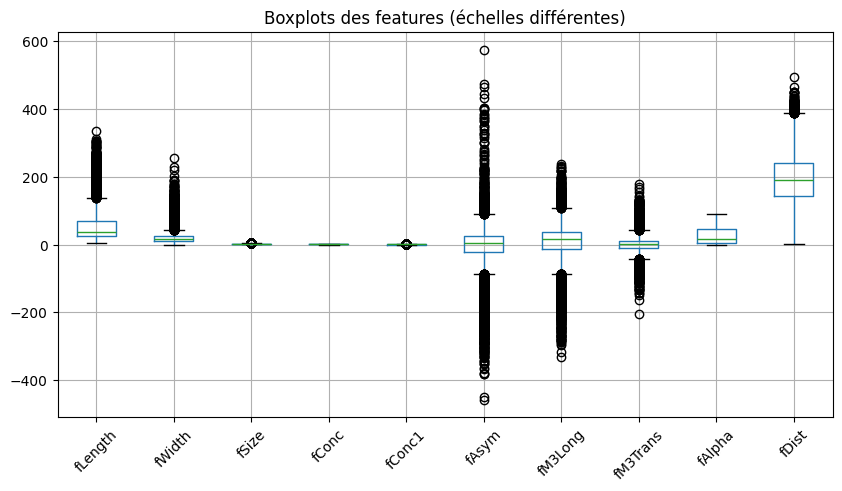

In [3]:
plt.figure(figsize=(10,5))
df.drop(columns="class").boxplot()
plt.xticks(rotation=45)
plt.title("Boxplots des features (échelles différentes)")
plt.show()

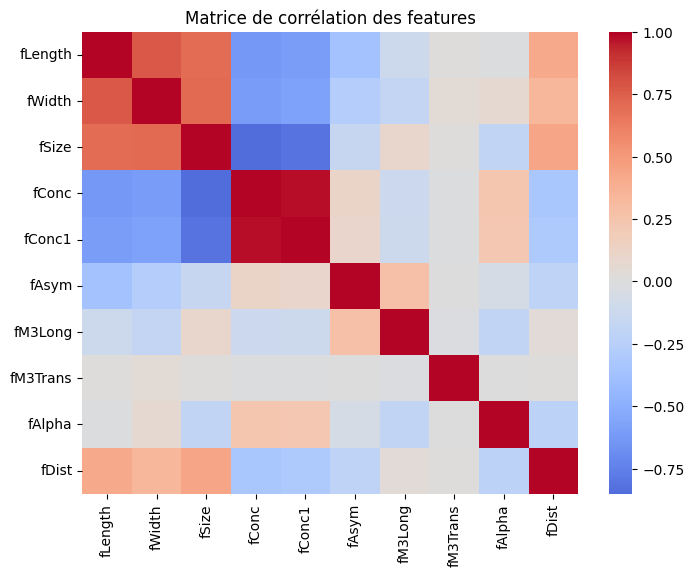

In [4]:
import seaborn as sns

plt.figure(figsize=(8,6))
corr = df.drop(columns="class").corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Matrice de corrélation des features")
plt.show()

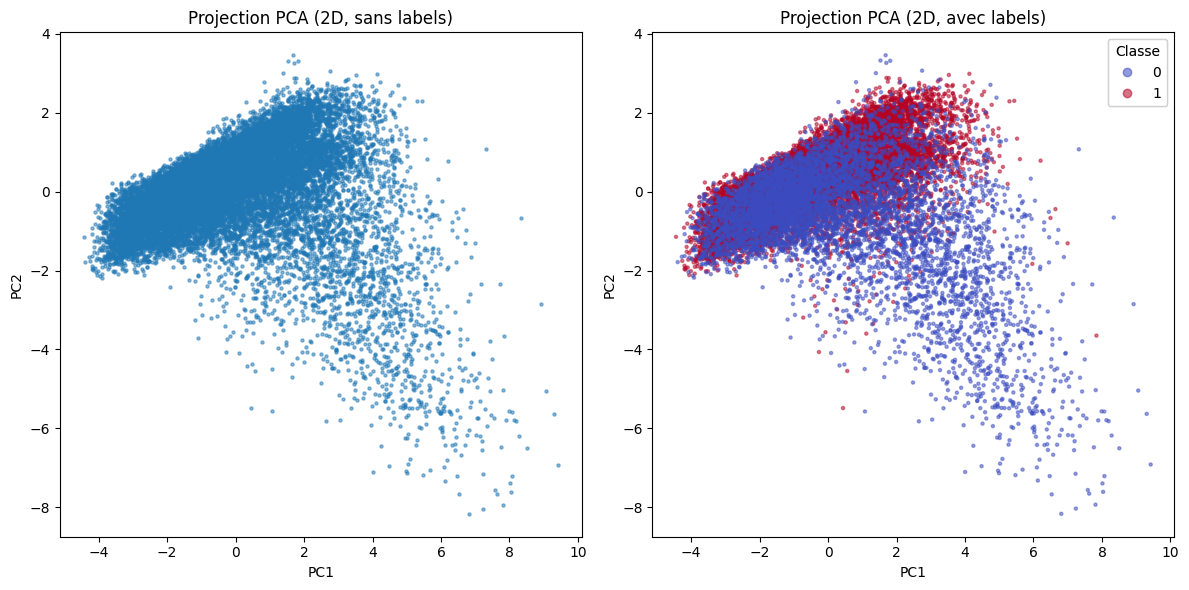

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- PCA 2D ---
X = df.drop(columns="class").values
Xz = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xz)

# --- Figure avec 2 sous-graphiques (côte à côte) ---
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Sans labels
axes[0].scatter(X_pca[:,0], X_pca[:,1], s=5, alpha=0.5)
axes[0].set_title("Projection PCA (2D, sans labels)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# Avec labels (gamma/hadron)
scatter = axes[1].scatter(X_pca[:,0], X_pca[:,1], c=(y=="g"), cmap="coolwarm", s=5, alpha=0.5)
axes[1].set_title("Projection PCA (2D, avec labels)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

# Légende pour labels
legend1 = axes[1].legend(*scatter.legend_elements(), title="Classe")
axes[1].add_artist(legend1)

plt.tight_layout()
plt.show()


In [6]:
import pandas as pd

print("=== Distribution des classes ===")
print(df["class"].value_counts())

print("\n=== Proportions (%) ===")
print(df["class"].value_counts(normalize=True).round(3) * 100)

print("\n=== Aperçu du dataset ===")
display(df.head(10))

=== Distribution des classes ===
class
g    12332
h     6688
Name: count, dtype: int64

=== Proportions (%) ===
class
g    64.8
h    35.2
Name: proportion, dtype: float64

=== Aperçu du dataset ===


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
5,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.0980,g
6,48.2468,17.3565,3.0332,0.2529,0.1515,8.5730,38.0957,10.5868,4.7920,219.0870,g
7,26.7897,13.7595,2.5521,0.4236,0.2174,29.6339,20.4560,-2.9292,0.8120,237.1340,g
8,96.2327,46.5165,4.1540,0.0779,0.0390,110.3550,85.0486,43.1844,4.8540,248.2260,g
9,46.7619,15.1993,2.5786,0.3377,0.1913,24.7548,43.8771,-6.6812,7.8750,102.2510,g


In [7]:
# --- Fabriques (constructeurs) par variante, paramétrées par k ---
def make_kmeans(k, random_state=0):
    return KMeans(n_clusters=k, init="k-means++", n_init="auto", random_state=random_state)

def make_minibatch(k, random_state=0):
    return MiniBatchKMeans(n_clusters=k, random_state=random_state)

def make_bisecting(k, random_state=0):
    return BisectingKMeans(n_clusters=k, random_state=random_state)

constructeurs = {
    "KMeans++":  make_kmeans,
    "MiniBatch": make_minibatch,
    "Bisecting": make_bisecting,
}

# --- Évaluation interne pour une variante sur une grille de k ---
def evaluer_variante(ctor, Xz, ks=range(2, 20)):
    """
    Retourne un DataFrame (k, silhouette, DBI, CH, inertia).
    """
    lignes = []
    for k in ks:
        model = ctor(k)
        labels = model.fit_predict(Xz)
        sil = silhouette_score(Xz, labels)
        dbi = davies_bouldin_score(Xz, labels)
        ch  = calinski_harabasz_score(Xz, labels)
        inertia = getattr(model, "inertia_", np.nan)  # Bisecting n'a pas cet attribut
        lignes.append({"k": k, "silhouette": sil, "DBI": dbi, "CH": ch, "inertia": inertia})
    return pd.DataFrame(lignes)
def choisir_k(df_scores):
    """
    Critère : maximiser Silhouette, puis minimiser DBI, puis maximiser CH.
    Renvoie: (k*, ligne)
    """
    key = lambda r: (r["silhouette"], -r["DBI"], r["CH"])
    best_idx = max(df_scores.index, key=lambda i: key(df_scores.loc[i]))
    return int(df_scores.loc[best_idx, "k"]), df_scores.loc[best_idx]

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def tracer_courbes_combinees(scores_par_variante, titre="Comparaison des variantes (scores vs k)"):
    # --- Récupérer la grille de k (on prend celle du premier df) ---
    any_df = next(iter(scores_par_variante.values()))
    ks = any_df["k"].values

    # --- Préparer la figure : 2x2 sous-graphiques ---
    fig, axes = plt.subplots(2, 2, figsize=(10, 7))
    ax = axes.ravel()

    # --- 1) Inertia (si disponible) ---

    has_inertia = all("inertia" in df.columns for df in scores_par_variante.values())
    if has_inertia:
        for nom, df in scores_par_variante.items():
            ax[0].plot(df["k"], df["inertia"], marker="o", label=nom)
        ax[0].set_title("Inertia (coude)")
        ax[0].set_xlabel("k"); ax[0].set_ylabel("SSE")
        ax[0].legend()
    else:
        ax[0].axis("off")  #

    # --- 2) Silhouette ---
    for nom, df in scores_par_variante.items():
        ax[1].plot(df["k"], df["silhouette"], marker="o", label=nom)
    ax[1].set_title("Silhouette (↑ mieux)")
    ax[1].set_xlabel("k"); ax[1].set_ylabel("score")
    ax[1].legend()

    # --- 3) DBI ---
    for nom, df in scores_par_variante.items():
        ax[2].plot(df["k"], df["DBI"], marker="o", label=nom)
    ax[2].set_title("Davies–Bouldin (↓ mieux)")
    ax[2].set_xlabel("k"); ax[2].set_ylabel("index")
    ax[2].legend()

    # --- 4) CH ---
    for nom, df in scores_par_variante.items():
        ax[3].plot(df["k"], df["CH"], marker="o", label=nom)
    ax[3].set_title("Calinski–Harabasz (↑ mieux)")
    ax[3].set_xlabel("k"); ax[3].set_ylabel("index")
    ax[3].legend()

    for a in ax:
        try:
            a.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        except Exception:
            pass

    fig.suptitle(titre, y=1.02)
    fig.tight_layout()
    plt.show()

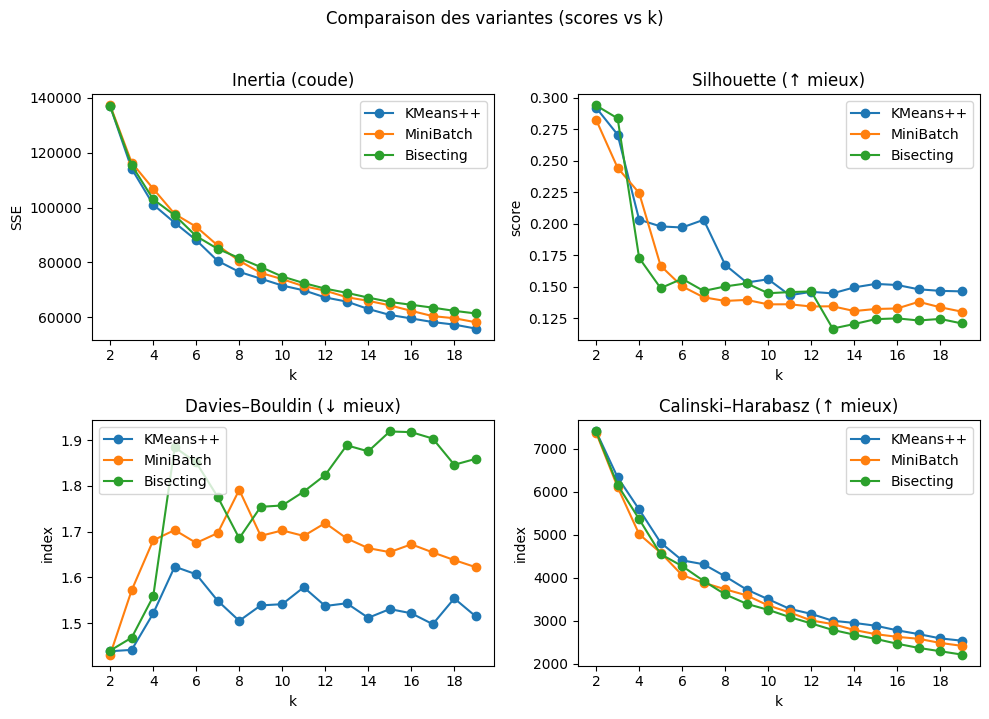

In [9]:
# --- Grille de k à tester ---
ks = range(2, 20)

# --- Évaluer chaque variante (mais ne pas tracer séparément) ---
scores_par_variante = {}
choix_par_variante = []

for nom, ctor in constructeurs.items():
    df_scores = evaluer_variante(ctor, Xz, ks)
    scores_par_variante[nom] = df_scores
    k_star, ligne = choisir_k(df_scores)
    choix_par_variante.append({
        "variante": nom, 
        "k": k_star,
        "silhouette": ligne["silhouette"],
        "DBI": ligne["DBI"], 
        "CH": ligne["CH"]
    })

# --- Tracer courbes comparées (fonction combinée) ---
tracer_courbes_combinees(scores_par_variante, "Comparaison des variantes (scores vs k)")

In [10]:
for nom, df_scores in scores_par_variante.items():
    print(f"\n=== Scores détaillés pour {nom} ===")
    display(df_scores.round(4))


=== Scores détaillés pour KMeans++ ===


,k,silhouette,DBI,CH,inertia
0,2,0.2922,1.4386,7399.0142,136928.1152
1,3,0.2708,1.4416,6333.4661,114159.9745
2,4,0.2032,1.5211,5587.3829,101090.8941
3,5,0.1979,1.6234,4817.0116,94471.7057
4,6,0.1970,1.6067,4404.6409,88126.5836
5,7,0.2031,1.5488,4313.6793,80549.4589
6,8,0.1673,1.5051,4032.2903,76550.3999
7,9,0.1533,1.5387,3725.6322,74071.8569
8,10,0.1559,1.5414,3501.0638,71570.3627
9,11,0.1432,1.5783,3277.4025,69820.4879



=== Scores détaillés pour MiniBatch ===


,k,silhouette,DBI,CH,inertia
0,2,0.2826,1.4313,7371.8779,137240.6224
1,3,0.2444,1.5719,6105.8375,116373.6311
2,4,0.2245,1.6809,5013.6802,106881.5090
3,5,0.1665,1.7034,4582.0521,97663.1335
4,6,0.1502,1.6752,4060.0270,93010.2773
5,7,0.1415,1.6968,3884.1185,86178.4327
6,8,0.1386,1.7911,3732.1210,80614.4956
7,9,0.1395,1.6907,3591.1004,76162.6465
8,10,0.1359,1.7025,3356.7876,73903.1264
9,11,0.1360,1.6905,3193.7626,71318.9964



=== Scores détaillés pour Bisecting ===


,k,silhouette,DBI,CH,inertia
0,2,0.2940,1.4400,7399.2146,136927.1351
1,3,0.2838,1.4682,6155.9619,115453.7501
2,4,0.1729,1.5582,5363.1111,103028.4961
3,5,0.1488,1.8842,4548.8672,97194.8357
4,6,0.1563,1.8511,4271.0302,89585.0518
5,7,0.1466,1.7757,3926.5581,84944.3975
6,8,0.1502,1.6854,3614.6236,81600.8126
7,9,0.1526,1.7541,3394.5567,78321.3047
8,10,0.1448,1.7570,3254.1235,74863.8019
9,11,0.1457,1.7873,3087.7586,72474.6989


In [11]:
# --- Tableau récapitulatif des meilleurs choix par variante ---
recap = pd.DataFrame(choix_par_variante).sort_values(by=["silhouette","CH"], ascending=[False, False])
print("=== Meilleurs choix (par variante) ===")
display(recap.round(4))

=== Meilleurs choix (par variante) ===


,variante,k,silhouette,DBI,CH
2,Bisecting,2,0.2940,1.4400,7399.2146
0,KMeans++,2,0.2922,1.4386,7399.0142
1,MiniBatch,2,0.2826,1.4313,7371.8779


### Choix de la variante

Les résultats montrent que pour $k=2$, les trois variantes obtiennent des scores très proches :  
- Silhouette ≈ 0.29  
- DBI ≈ 1.43–1.44  
- CH ≈ 7399  

Il n’y a donc pas d’avantage net pour MiniBatchKMeans ou BisectingKMeans.  
Étant donné que notre dataset n’est pas massif (≈ 19 000 échantillons), **l’intérêt de MiniBatchKMeans est limité**.  
De plus, **BisectingKMeans** est surtout utile pour construire une structure hiérarchique explicative, ce qui n’est pas l’objectif principal ici.  

Nous retenons donc **KMeans (k-means++)** comme variante de référence :  
- Initialisation plus fiable que le K-means aléatoire.  
- Résultats comparables aux autres variantes sur nos indicateurs internes.  
- Implémentation simple, stable et reproductible.  


In [12]:
# --- Règle de décision finale ---
# Par défaut, prendre la première ligne (meilleure silhouette, puis CH).
final_variante  = recap.iloc[0]["variante"]
final_k = int(recap.iloc[0]["k"])

# Préférence douce pour KMeans++ si ses scores sont très proches du top (ΔSilhouette ≤ 0.01)
if "KMeans++" in recap["variante"].values:
    row_km = recap[recap["variante"]=="KMeans++"].iloc[0]
    if recap.iloc[0]["silhouette"] - row_km["silhouette"] <= 0.01:
        final_variante = "KMeans++"
        final_k = int(row_km["k"])

print(f">>> Proposition pour Q3 : variante = {final_variante} , k = {final_k}")


>>> Proposition pour Q3 : variante = KMeans++ , k = 2


## 4) Comparaison entre l’algorithme choisi et le K-means standard

Dans la question précédente (Q3), nous avons retenu **KMeans (k-means++)** comme variante adaptée.  
L’objectif ici est de comparer cette variante au **K-means standard (init aléatoire)**, en utilisant le **même nombre de clusters $k$**.

### Méthodologie
1. **Appliquer KMeans (k-means++)** et **KMeans (init="random")** avec $k=2$ (choisi en Q3).  
2. Calculer les **indicateurs internes** (sans labels) : Silhouette, Davies–Bouldin (DBI), Calinski–Harabasz (CH), Inertia.  
3. Calculer les **indicateurs externes** (avec labels gamma/hadron) : Pureté, ARI, NMI.  
4. Comparer les résultats et conclure sur la stabilité et la qualité de l’initialisation k-means++.  



In [13]:
# --- Appliquer KMeans++ (variante choisie) ---
k = 2  # valeur optimale trouvée à Q3
kmeans_plus = KMeans(n_clusters=k, init="k-means++", n_init="auto", random_state=0).fit(Xz)
labels_plus = kmeans_plus.labels_

# --- Appliquer KMeans standard (init aléatoire) ---
kmeans_std = KMeans(n_clusters=k, init="random", n_init=10, random_state=0).fit(Xz)
labels_std = kmeans_std.labels_


In [14]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# --- Indicateurs internes ---
def eval_internes(Xz, labels, model):
    return {
        "silhouette": silhouette_score(Xz, labels),
        "DBI": davies_bouldin_score(Xz, labels),
        "CH": calinski_harabasz_score(Xz, labels),
        "inertia": getattr(model, "inertia_", None)
    }

# --- Pureté (fonction maison) ---
def purity_score(y_true, y_pred):
    contingency = pd.crosstab(y_pred, y_true)
    return np.sum(np.max(contingency.values, axis=1)) / np.sum(contingency.values)

# --- Indicateurs externes ---
def eval_externes(y_true, labels):
    return {
        "purity": purity_score(y_true, labels),
        "ARI": adjusted_rand_score(y_true, labels),
        "NMI": normalized_mutual_info_score(y_true, labels)
    }


In [15]:
# --- Résultats internes ---
internes_plus = eval_internes(Xz, labels_plus, kmeans_plus)
internes_std  = eval_internes(Xz, labels_std, kmeans_std)

# --- Résultats externes ---
externes_plus = eval_externes(y, labels_plus)
externes_std  = eval_externes(y, labels_std)

# Créer un DataFrame avec des labels plus explicites
comparaison = pd.DataFrame({
    "KMeans++": {**internes_plus, **externes_plus},
    "KMeans std": {**internes_std, **externes_std}
}).T.round(4)

# Renommer les colonnes avec une indication ↑ / ↓
comparaison = comparaison.rename(columns={
    "silhouette": "Silhouette (↑)",
    "DBI": "DBI (↓)",
    "CH": "CH (↑)",
    "inertia": "Inertia (↓)",
    "purity": "Purity (↑)",
    "ARI": "ARI (↑)",
    "NMI": "NMI (↑)"
})

display(comparaison)


,Silhouette (↑),DBI (↓),CH (↑),Inertia (↓),Purity (↑),ARI (↑),NMI (↑)
KMeans++,0.2922,1.4386,7399.0142,136928.1152,0.6484,0.0058,0.0014
KMeans std,0.2940,1.4400,7399.2146,136927.1351,0.6484,0.0065,0.0016


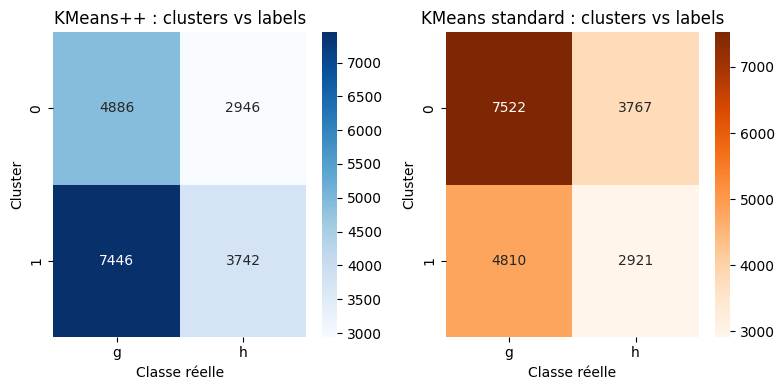

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Construction d'une matrice de contingence (clusters vs classes vraies)
cm_plus = pd.crosstab(labels_plus, y, rownames=["Cluster"], colnames=["Classe réelle"])
cm_std  = pd.crosstab(labels_std, y, rownames=["Cluster"], colnames=["Classe réelle"])

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.heatmap(cm_plus, annot=True, fmt="d", cmap="Blues")
plt.title("KMeans++ : clusters vs labels")

plt.subplot(1,2,2)
sns.heatmap(cm_std, annot=True, fmt="d", cmap="Oranges")
plt.title("KMeans standard : clusters vs labels")

plt.tight_layout()
plt.show()


## Analyse et conclusion (Q4)

Les résultats montrent que **KMeans++** et **KMeans standard** donnent des partitions très similaires pour $k=2$.  

la matrice de contingence sert à observer comment les clusters obtenus correspondent (ou non) aux vraies classes.

- Chaque ligne = un cluster trouvé par K-means.  
- Chaque colonne = une classe réelle (gamma ou hadron).  
- Chaque cellule = le nombre d’échantillons d’une classe réelle se trouvant dans un cluster.

Exemple : si dans le Cluster 0 on a 4886 gamma et 2946 hadron,  
cela signifie que ce cluster contient une majorité de gamma, mais aussi beaucoup de hadron mélangés.  
 

K-means a bien séparé les données en **deux clusters** (selon $k=2$),  
mais ces clusters **ne correspondent pas directement** aux classes réelles (gamma / hadron).  

- L’algorithme ne connaît pas les étiquettes : il regroupe les points uniquement en fonction de la **proximité géométrique** (minimisation de la variance intra-cluster).  
- Dans ce dataset, les classes gamma et hadron **se mélangent fortement** dans l’espace des features.  
- Résultat : chaque cluster contient une majorité de gamma, et les hadrons sont dispersés.  
- **Indicateurs internes** (Silhouette, DBI, CH, Inertia) : les scores sont presque identiques, avec une légère amélioration pour KMeans++ en termes de stabilité (DBI plus bas).  
- **Indicateurs externes** (Purity, ARI, NMI) : les valeurs restent faibles pour les deux méthodes, ce qui confirme que la séparation gamma/hadron n’est pas bien capturée par K-means.  

Conclusion : K-means trouve bien une structure en 2 groupes, mais elle ne reflète pas les classes réelles.



### Tests supplémentaires avec 3 variantes

In [17]:
# --- Modèles à comparer (standard + 3 variantes) ---
models = {
    "KMeans std": KMeans(n_clusters=k, init="random", n_init=10, random_state=0),
    "KMeans++": KMeans(n_clusters=k, init="k-means++", n_init="auto", random_state=0),
    "MiniBatch": MiniBatchKMeans(n_clusters=k, random_state=0),
    "Bisecting": BisectingKMeans(n_clusters=k, random_state=0)
}

# --- Calculer les labels + indicateurs internes/externes ---
resultats = {}
for nom, model in models.items():
    labels = model.fit_predict(Xz)
    internes = eval_internes(Xz, labels, model)
    externes = eval_externes(y, labels)
    resultats[nom] = {**internes, **externes}

# --- Construire DataFrame comparatif ---
comparaison_all = pd.DataFrame(resultats).T.round(4)

# Renommer colonnes pour ajouter ↑ / ↓
comparaison_all = comparaison_all.rename(columns={
    "silhouette": "Silhouette (↑)",
    "DBI": "DBI (↓)",
    "CH": "CH (↑)",
    "inertia": "Inertia (↓)",
    "purity": "Purity (↑)",
    "ARI": "ARI (↑)",
    "NMI": "NMI (↑)"
})

display(comparaison_all)


,Silhouette (↑),DBI (↓),CH (↑),Inertia (↓),Purity (↑),ARI (↑),NMI (↑)
KMeans std,0.2940,1.4400,7399.2146,136927.1351,0.6484,0.0065,0.0016
KMeans++,0.2922,1.4386,7399.0142,136928.1152,0.6484,0.0058,0.0014
MiniBatch,0.2826,1.4313,7371.8779,137240.6224,0.6484,0.0030,0.0007
Bisecting,0.2940,1.4400,7399.2146,136927.1351,0.6484,0.0065,0.0016


## 5) Reprendre l’étude après réduction de dimension (ACP/PCA)



In [18]:
# --- PCA 2D ---
from sklearn.decomposition import PCA

pca2 = PCA(n_components=2).fit(Xz)
X_pca2 = pca2.transform(Xz)

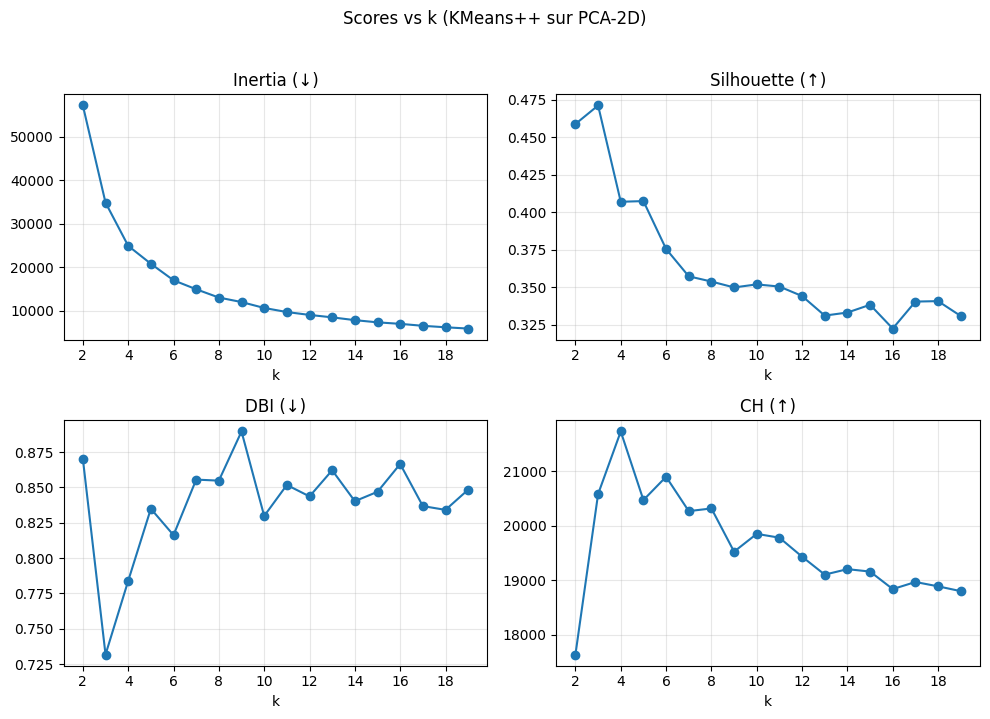

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.ticker as ticker

# --- Fabrique pour KMeans++ ---
def ctor_kmeans(k, rs=0):
    return KMeans(n_clusters=k, init="k-means++", n_init="auto", random_state=rs)

# --- Évaluer des k sur un espace donné (ici PCA-2D) ---
def evaluer_sur_X(ctor, X_input, ks=range(2, 20)):
    lignes = []
    for k in ks:
        model = ctor(k)
        labels = model.fit_predict(X_input)
        lignes.append({
            "k": k,
            "silhouette": silhouette_score(X_input, labels),
            "DBI": davies_bouldin_score(X_input, labels),
            "CH": calinski_harabasz_score(X_input, labels),
            "inertia": getattr(model, "inertia_", None)
        })
    return pd.DataFrame(lignes)
# --- 1) Balayer k ---
ks = range(2, 20)
scores_pca2 = evaluer_sur_X(ctor_kmeans, X_pca2, ks)

fig, axes = plt.subplots(2, 2, figsize=(10, 7))
ax = axes.ravel()

ax[0].plot(scores_pca2["k"], scores_pca2["inertia"], marker="o"); ax[0].set_title("Inertia (↓)")
ax[1].plot(scores_pca2["k"], scores_pca2["silhouette"], marker="o"); ax[1].set_title("Silhouette (↑)")
ax[2].plot(scores_pca2["k"], scores_pca2["DBI"], marker="o"); ax[2].set_title("DBI (↓)")
ax[3].plot(scores_pca2["k"], scores_pca2["CH"], marker="o"); ax[3].set_title("CH (↑)")

for a in ax:
    a.set_xlabel("k"); a.grid(True, alpha=0.3)
    a.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.suptitle("Scores vs k (KMeans++ sur PCA-2D)", y=1.02)
plt.tight_layout()
plt.show()


In [20]:
k_best_pca2, ligne_best = choisir_k(scores_pca2)
print(">>> Meilleur k (PCA-2D) :", k_best_pca2)
display(scores_pca2.round(4))

>>> Meilleur k (PCA-2D) : 3


,k,silhouette,DBI,CH,inertia
0,2,0.4588,0.8703,17639.1195,57225.4695
1,3,0.4711,0.7317,20581.4634,34855.4169
2,4,0.4070,0.7839,21728.8334,24910.7116
3,5,0.4074,0.8349,20471.7469,20786.2169
4,6,0.3755,0.8163,20898.5959,16981.4797
5,7,0.3573,0.8556,20268.9934,14913.0181
6,8,0.3538,0.8548,20317.9754,13006.0356
7,9,0.3499,0.8896,19525.4925,11968.0248
8,10,0.3519,0.8298,19851.9232,10607.5420
9,11,0.3505,0.8518,19781.8361,9670.0219


In [21]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import seaborn as sns

def purity_score(y_true, y_pred):
    contingency = pd.crosstab(y_pred, y_true)
    return np.sum(np.max(contingency.values, axis=1)) / np.sum(contingency.values)

def eval_internes(Xin, labels, model):
    return {
        "Silhouette (↑)": silhouette_score(Xin, labels),
        "DBI (↓)": davies_bouldin_score(Xin, labels),
        "CH (↑)": calinski_harabasz_score(Xin, labels),
        "Inertia (↓)": getattr(model, "inertia_", None)
    }

def eval_externes(y_true, labels):
    return {
        "Purity (↑)": purity_score(y_true, labels),
        "ARI (↑)": adjusted_rand_score(y_true, labels),
        "NMI (↑)": normalized_mutual_info_score(y_true, labels)
    }

k = int(k_best_pca2)

# 1) KMeans++ dans PCA-2D
km_plus = KMeans(n_clusters=k, init="k-means++", n_init="auto", random_state=0).fit(X_pca2)
lab_plus = km_plus.labels_

# 2) KMeans standard (init aléatoire) dans PCA-2D
km_std = KMeans(n_clusters=k, init="random", n_init=10, random_state=0).fit(X_pca2)
lab_std = km_std.labels_

res_plus = {**eval_internes(X_pca2, lab_plus, km_plus), **eval_externes(y, lab_plus)}
res_std  = {**eval_internes(X_pca2, lab_std,  km_std),  **eval_externes(y, lab_std)}

comparaison_pca2 = pd.DataFrame([res_plus, res_std],
                                index=["KMeans++ (PCA-2D)", "KMeans std (PCA-2D)"]).round(4)

comparaison_pca2 = comparaison_pca2.rename(columns={
    "Silhouette (↑)":"Silhouette (↑)",
    "DBI (↓)":"DBI (↓)",
    "CH (↑)":"CH (↑)",
    "Inertia (↓)":"Inertia (↓)",
    "Purity (↑)":"Purity (↑)",
    "ARI (↑)":"ARI (↑)",
    "NMI (↑)":"NMI (↑)"
})
display(comparaison_pca2)


,Silhouette (↑),DBI (↓),CH (↑),Inertia (↓),Purity (↑),ARI (↑),NMI (↑)
KMeans++ (PCA-2D),0.4711,0.7317,20581.4634,34855.4169,0.7158,0.0687,0.0932
KMeans std (PCA-2D),0.4707,0.7327,20581.8264,34855.0323,0.7162,0.0694,0.0934


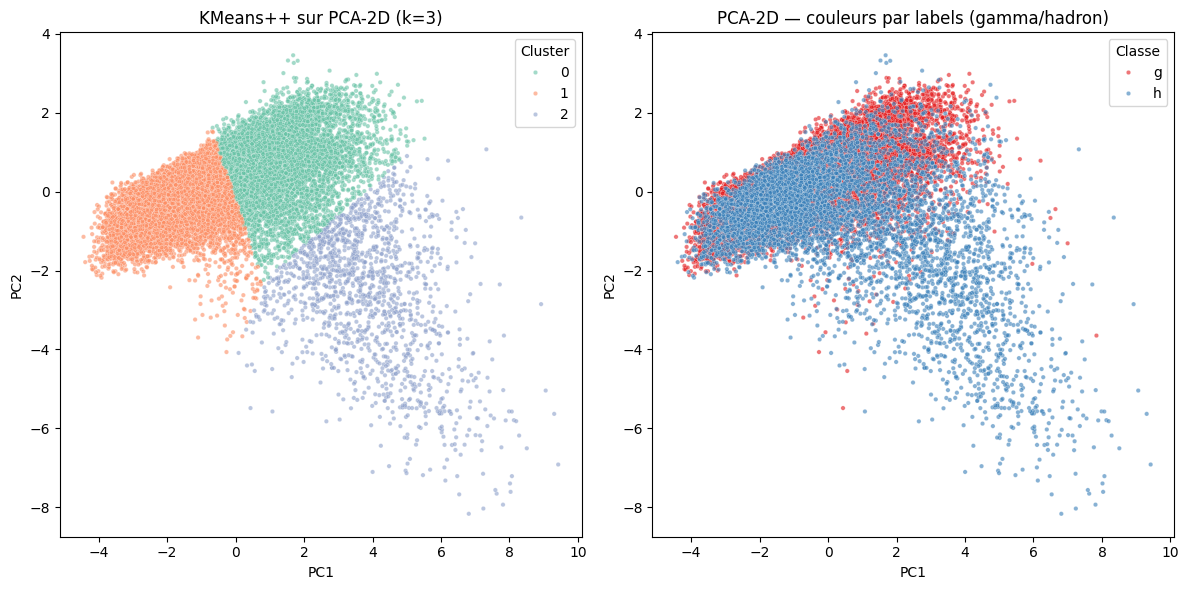

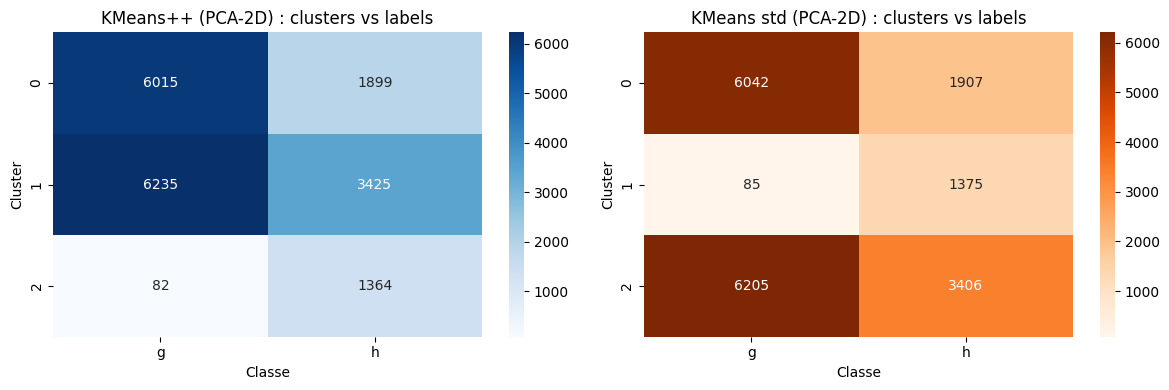

In [22]:
# --- 1)clusters vs labels（PCA-2D ） ---
fig, axes = plt.subplots(1, 2, figsize=(12,6))

sns.scatterplot(ax=axes[0], x=X_pca2[:,0], y=X_pca2[:,1],
                hue=lab_plus, palette="Set2", s=10, alpha=0.6, legend="full")
axes[0].set_title(f"KMeans++ sur PCA-2D (k={k})")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")
axes[0].legend(title="Cluster")

sns.scatterplot(ax=axes[1], x=X_pca2[:,0], y=X_pca2[:,1],
                hue=y, palette="Set1", s=10, alpha=0.6, legend="full")
axes[1].set_title("PCA-2D — couleurs par labels (gamma/hadron)")
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")
axes[1].legend(title="Classe")

plt.tight_layout()
plt.show()

# --- 2) matrice de contingence（clusters vs labels）---
cm_plus = pd.crosstab(lab_plus, y, rownames=["Cluster"], colnames=["Classe"])
cm_std  = pd.crosstab(lab_std,  y, rownames=["Cluster"], colnames=["Classe"])

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.heatmap(cm_plus, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("KMeans++ (PCA-2D) : clusters vs labels")

sns.heatmap(cm_std, annot=True, fmt="d", cmap="Oranges", ax=axes[1])
axes[1].set_title("KMeans std (PCA-2D) : clusters vs labels")

plt.tight_layout()
plt.show()


### Tests supplémentaires avec k = 2

In [23]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1) PCA (2 composantes) ---
pca2 = PCA(n_components=2).fit(Xz)
X_pca2 = pca2.transform(Xz)



In [24]:
from sklearn.cluster import KMeans

k_comm = 2  # <-- utiliser la même valeur de k que précédemment

# --- Clustering KMeans++ dans l'espace original (10D) ---
km_raw = KMeans(n_clusters=k_comm, init="k-means++", n_init="auto", random_state=0).fit(Xz)
lab_raw = km_raw.labels_

# --- Clustering KMeans++ dans l'espace PCA-2D ---
km_pca = KMeans(n_clusters=k_comm, init="k-means++", n_init="auto", random_state=0).fit(X_pca2)
lab_pca = km_pca.labels_

# --- Indicateurs internes + externes ---
res_raw = {**eval_internes(Xz, lab_raw, km_raw), **eval_externes(y, lab_raw)}
res_pca = {**eval_internes(X_pca2, lab_pca, km_pca), **eval_externes(y, lab_pca)}

comparaison_pca = pd.DataFrame([res_raw, res_pca], index=["Original (10D)", "PCA (2D)"]).round(4)

# Noms de colonnes explicites (↑ / ↓)
comparaison_pca = comparaison_pca.rename(columns={
    "Silhouette (↑)":"Silhouette (↑)",
    "DBI (↓)":"DBI (↓)",
    "CH (↑)":"CH (↑)",
    "Inertia (↓)":"Inertia (↓)",
    "Purity (↑)":"Purity (↑)",
    "ARI (↑)":"ARI (↑)",
    "NMI (↑)":"NMI (↑)"
})

display(comparaison_pca)


,Silhouette (↑),DBI (↓),CH (↑),Inertia (↓),Purity (↑),ARI (↑),NMI (↑)
Original (10D),0.2922,1.4386,7399.0142,136928.1152,0.6484,0.0058,0.0014
PCA (2D),0.4588,0.8703,17639.1195,57225.4695,0.6484,0.0057,0.0014


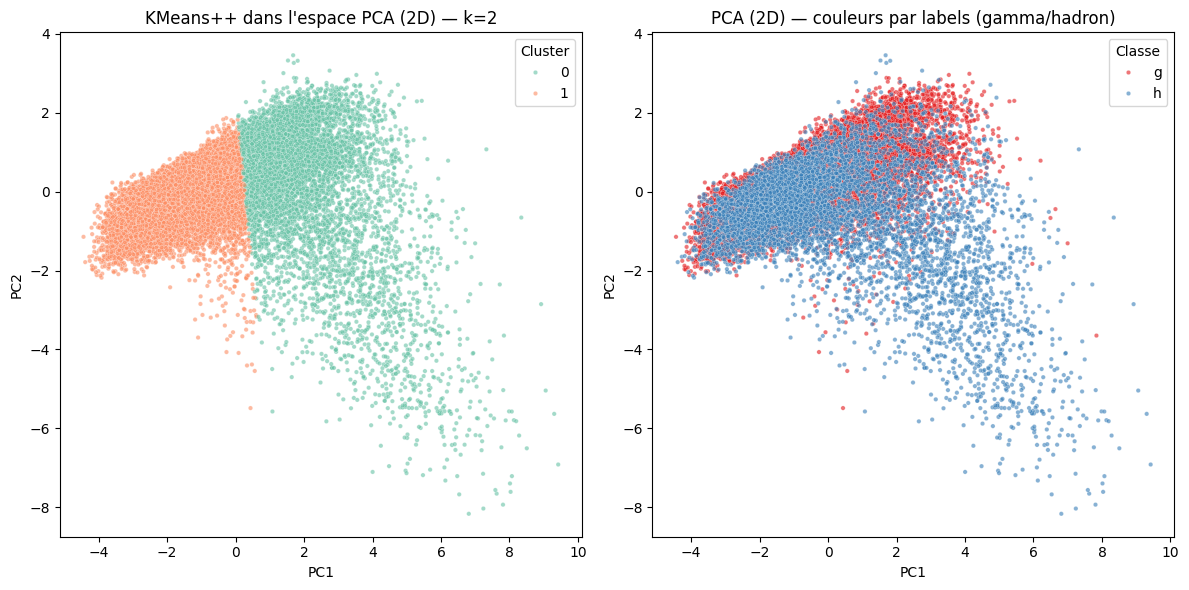

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# --- 1) PCA 2D + clusters KMeans ---
sns.scatterplot(ax=axes[0], x=X_pca2[:,0], y=X_pca2[:,1], 
                hue=lab_pca, palette="Set2", s=10, alpha=0.6, legend="full")
axes[0].set_title(f"KMeans++ dans l'espace PCA (2D) — k={k_comm}")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")
axes[0].legend(title="Cluster")

# --- 2) PCA 2D + labels réels ---
sns.scatterplot(ax=axes[1], x=X_pca2[:,0], y=X_pca2[:,1], 
                hue=y, palette="Set1", s=10, alpha=0.6, legend="full")
axes[1].set_title("PCA (2D) — couleurs par labels (gamma/hadron)")
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")
axes[1].legend(title="Classe")

plt.tight_layout()
plt.show()
